In [14]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import csv
from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer

# Set random seed for reproducibility
torch.manual_seed(42)

# Device
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: mps


# MNIST Dataset

In [5]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
    # Expand to 3 channels for compatibility with the model
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x)
])

# Load MNIST training dataset
dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

In [10]:
# Create train / test split

batch_size = 32
split_ratio = 0.8
train_size = int(len(dataset) * split_ratio)
test_size = len(dataset) - train_size

train_ds, test_ds = random_split(
    dataset,
    [train_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print(f"Dataset size: {len(dataset)}")
print(f"Train size: {len(train_ds)} | Test size: {len(test_ds)}")
print(f"Train batches: {len(train_loader)} | Test batches: {len(test_loader)}")

Dataset size: 60000
Train size: 48000 | Test size: 12000
Train batches: 1500 | Test batches: 375


## Model Architecture

In [20]:
# Create model
model = Unet(
    dim=64,
    dim_mults=(1, 2, 4),
    channels=3,  # 3 channels for grayscale images expanded to 3 channels
    flash_attn=False  # Set to False if flash_attn is not available
)

# Create diffusion model
diffusion = GaussianDiffusion(
    model,
    image_size=28,
    timesteps=1000,
    sampling_timesteps=250
)

In [ ]:
#trains_counter = 1  # Counter for number of training runs

In [15]:
trains_counter += 1

# Move model to device
diffusion = diffusion.to(device)

# Create checkpoint directory
os.makedirs('checkpoints', exist_ok=True)

# Create CSV for logging
csv_file = f'checkpoints/training_metrics_{trains_counter}.csv'

# Training loop
num_epochs = 5
learning_rate = 1e-4
optimizer = torch.optim.Adam(diffusion.parameters(), lr=learning_rate)

best_val_loss = float('inf')
training_losses = []
validation_losses = []
global_iteration = 0

print(f"\nStarting training number {trains_counter}...")
diffusion.train()

for epoch in range(num_epochs):

    # Training phase
    train_loss = 0
    train_pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    
    for batch_idx, (images, _) in train_pbar:
        images = images.to(device)
        
        # Compute loss
        loss = diffusion(images)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        global_iteration += 1
        
        # Log every 100 iterations
        if batch_idx % 100 == 0:
            current_loss = loss.item()
            train_pbar.set_postfix({'loss': f"{current_loss:.4f}"})
            
            # Write to CSV every 100 iterations
            with open(csv_file, 'a', newline='') as f:
                writer = csv.writer(f)
                if batch_idx == 0 and epoch == 0:
                    writer.writerow(['Epoch', 'Iteration', 'Type', 'Loss'])
                writer.writerow([epoch + 1, global_iteration, 'train', f"{current_loss:.6f}"])
    
    avg_train_loss = train_loss / len(train_loader)
    training_losses.append(avg_train_loss)
    
    # Evaluation phase
    diffusion.eval()
    val_loss = 0
    val_pbar = tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
    
    with torch.no_grad():
        for batch_idx, (images, _) in val_pbar:
            images = images.to(device)
            loss = diffusion(images)
            val_loss += loss.item()
            
            if batch_idx % 50 == 0:
                val_pbar.set_postfix({'loss': f"{loss.item():.4f}"})
    
    avg_val_loss = val_loss / len(test_loader)
    validation_losses.append(avg_val_loss)
    
    # Log validation loss at end of epoch
    with open(csv_file, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch + 1, global_iteration, 'validation', f"{avg_val_loss:.6f}"])
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    
    # Save model checkpoint every epoch
    checkpoint_path = f'checkpoints/model_epoch_{epoch+1}_{trains_counter}.pt'
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': diffusion.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
    }, checkpoint_path)
    print(f"Checkpoint saved: {checkpoint_path}")
    
    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_path = f'checkpoints/best_model_{trains_counter}.pt'
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': diffusion.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
        }, best_model_path)
        print(f"Best model saved: {best_model_path} (Val Loss: {best_val_loss:.4f})")
    
    diffusion.train()

print("Training completed!")
print(f"\nBest validation loss: {best_val_loss:.4f}")
print(f"Metrics logged to: {csv_file}")


Starting training number 2...


Epoch 1/5 [Val]: 100%|██████████| 375/375 [00:29<00:00, 12.92it/s, loss=0.0269]


Epoch 1/5 - Train Loss: 0.0634, Val Loss: 0.0291
Checkpoint saved: checkpoints/model_epoch_1_2.pt
Best model saved: checkpoints/best_model_2.pt (Val Loss: 0.0291)


Epoch 2/5 [Val]: 100%|██████████| 375/375 [00:31<00:00, 11.87it/s, loss=0.0238]


Epoch 2/5 - Train Loss: 0.0271, Val Loss: 0.0239
Checkpoint saved: checkpoints/model_epoch_2_2.pt
Best model saved: checkpoints/best_model_2.pt (Val Loss: 0.0239)


Epoch 3/5 [Val]: 100%|██████████| 375/375 [00:31<00:00, 12.07it/s, loss=0.0292]


Epoch 3/5 - Train Loss: 0.0230, Val Loss: 0.0218
Checkpoint saved: checkpoints/model_epoch_3_2.pt
Best model saved: checkpoints/best_model_2.pt (Val Loss: 0.0218)


Epoch 4/5 [Val]: 100%|██████████| 375/375 [00:28<00:00, 13.11it/s, loss=0.0284]


Epoch 4/5 - Train Loss: 0.0211, Val Loss: 0.0208
Checkpoint saved: checkpoints/model_epoch_4_2.pt
Best model saved: checkpoints/best_model_2.pt (Val Loss: 0.0208)


Epoch 5/5 [Val]: 100%|██████████| 375/375 [00:31<00:00, 11.93it/s, loss=0.0244]


Epoch 5/5 - Train Loss: 0.0202, Val Loss: 0.0187
Checkpoint saved: checkpoints/model_epoch_5_2.pt
Best model saved: checkpoints/best_model_2.pt (Val Loss: 0.0187)
Training completed!

Best validation loss: 0.0187
Metrics logged to: checkpoints/training_metrics_2.csv


# Evaluation


Generating samples...


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Generated images shape: torch.Size([4, 3, 28, 28])


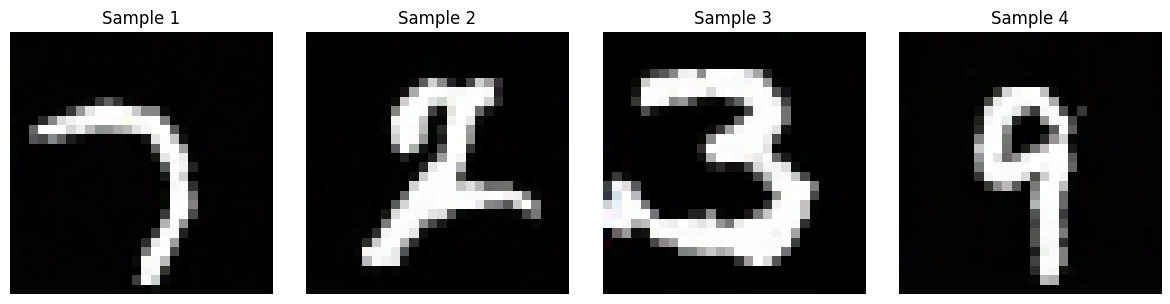

Samples saved to 'generated_samples.png'


In [16]:
# Generate samples
print("\nGenerating samples...")
diffusion.eval()
with torch.no_grad():
    sampled_images = diffusion.sample(batch_size=4)
    print(f"Generated images shape: {sampled_images.shape}")

# Visualize generated samples
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    img = sampled_images[i].cpu().permute(1, 2, 0).squeeze()
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'Sample {i+1}')
    axes[i].axis('off')
plt.tight_layout()
#plt.savefig('generated_samples.png')
plt.show()

print("Samples saved to 'generated_samples.png'")

In [37]:
validation_losses

[0.029121, 0.023895, 0.021846, 0.020811, 0.018658]

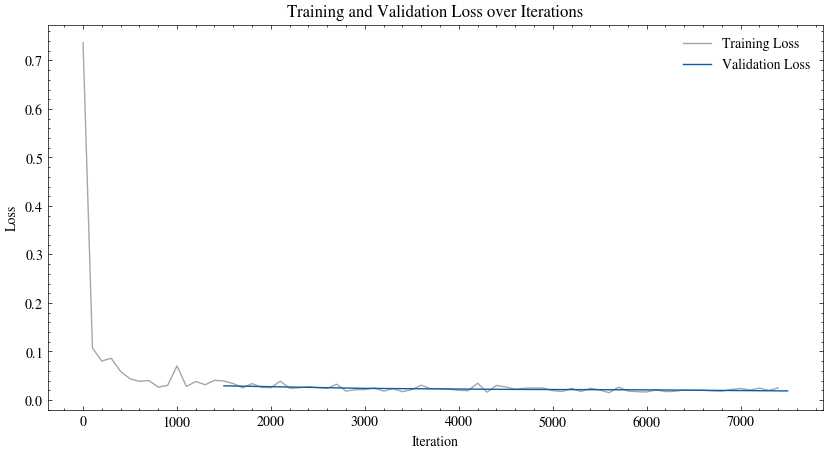

In [ ]:
# see validation and training plot
import scienceplots
plt.style.use(['science', 'no-latex'])

import pandas as pd
df = pd.read_csv("checkpoints/training_metrics_2.csv")

training_losses = df[df['Type'] == 'train']
validation_losses = df[df['Type'] == 'validation']

plt.figure(figsize=(10, 5))
plt.plot(training_losses.Iteration, training_losses.Loss, label='Training Loss', alpha=0.7, color='gray')
plt.plot(validation_losses.Iteration, validation_losses.Loss, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Iterations')
plt.legend()
plt.show()
plt.save


## Measuring Generalization

In [22]:
# 1. Load the Best Weights from the Experiment Folder

# Recreate the model architecture
loaded_model = Unet(
    dim=64,
    dim_mults=(1, 2, 4),
    channels=3,
    flash_attn=False
)

# Recreate the diffusion model
loaded_diffusion = GaussianDiffusion(
    loaded_model,
    image_size=28,
    timesteps=1000,
    sampling_timesteps=250
).to(device)

# Load checkpoint
checkpoint = torch.load(
    "checkpoints/best_model_2.pt",  # Changed .pth to .pt to match save format
    map_location=device
)
loaded_diffusion.load_state_dict(checkpoint["model_state_dict"])
loaded_diffusion.eval()

print("Model loaded successfully!")

Model loaded successfully!


In [23]:
# Create Images
print("\nGenerating samples...")
with torch.no_grad():
    sampled_images = loaded_diffusion.sample(batch_size=1000)
    print(f"Generated images shape: {sampled_images.shape}")


Generating samples...


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Generated images shape: torch.Size([1000, 3, 28, 28])


In [25]:
import lpips
import numpy as np

# Initialize LPIPS model (using AlexNet as the feature extractor)
lpips_model = lpips.LPIPS(net='alex').to(device)
lpips_model.eval()

print("LPIPS model loaded successfully!")

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /Users/chelsymena/env_pytorch/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth
LPIPS model loaded successfully!


In [27]:
# Compute LPIPS distances between generated samples and training dataset

# Normalize images to [-1, 1] range (required by LPIPS)
def normalize_for_lpips(images):
    """Normalize images from [0, 1] to [-1, 1]"""
    return images * 2 - 1

# Resize images to minimum size for LPIPS (64x64)
def resize_for_lpips(images, size=64):
    """Resize images to required size for LPIPS"""
    return F.interpolate(images, size=(size, size), mode='bilinear', align_corners=False)

# Get a subset of training data for comparison
num_train_samples = 1000  # Use 1000 training samples for comparison
train_subset_indices = torch.randperm(len(train_ds))[:num_train_samples]
train_images = []

print("Loading training samples...")
for idx in tqdm(train_subset_indices):
    img, _ = train_ds[idx]
    train_images.append(img)

train_images = torch.stack(train_images).to(device)
print(f"Loaded {len(train_images)} training images")

# Resize and normalize images
generated_resized = resize_for_lpips(sampled_images)
train_resized = resize_for_lpips(train_images)

generated_normalized = normalize_for_lpips(generated_resized)
train_normalized = normalize_for_lpips(train_resized)

print(f"Resized image shape: {generated_normalized.shape}")

# Compute LPIPS distances
print("\nComputing LPIPS distances...")
lpips_distances = []

with torch.no_grad():
    for i, gen_img in enumerate(tqdm(generated_normalized, desc="Computing LPIPS")):
        # Compute distance to all training images
        gen_img_batch = gen_img.unsqueeze(0).repeat(len(train_normalized), 1, 1, 1)
        distances = lpips_model(gen_img_batch, train_normalized).squeeze()
        
        # Get minimum distance (closest training sample)
        min_distance = distances.min().item()
        lpips_distances.append(min_distance)

lpips_distances = np.array(lpips_distances)

# Compute creativity metric (mean LPIPS distance)
creativity_score = lpips_distances.mean()
creativity_std = lpips_distances.std()

print(f"\n{'='*50}")
print(f"LPIPS Creativity Metrics:")
print(f"{'='*50}")
print(f"Mean LPIPS distance: {creativity_score:.4f}")
print(f"Std LPIPS distance: {creativity_std:.4f}")
print(f"Min LPIPS distance: {lpips_distances.min():.4f}")
print(f"Max LPIPS distance: {lpips_distances.max():.4f}")
print(f"{'='*50}")

Loading training samples...


100%|██████████| 1000/1000 [00:00<00:00, 6308.95it/s]


Loaded 1000 training images
Resized image shape: torch.Size([1000, 3, 64, 64])

Computing LPIPS distances...


Computing LPIPS: 100%|██████████| 1000/1000 [03:01<00:00,  5.50it/s]


LPIPS Creativity Metrics:
Mean LPIPS distance: 0.1038
Std LPIPS distance: 0.0323
Min LPIPS distance: 0.0169
Max LPIPS distance: 0.2157


Loading validation samples...


100%|██████████| 15/15 [00:00<00:00, 1156.69it/s]

Generating samples with all timesteps...


sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

Captured 251 timesteps
Computing mean LPIPS per timestep...


LPIPS per t: 100%|██████████| 251/251 [00:09<00:00, 25.89it/s]


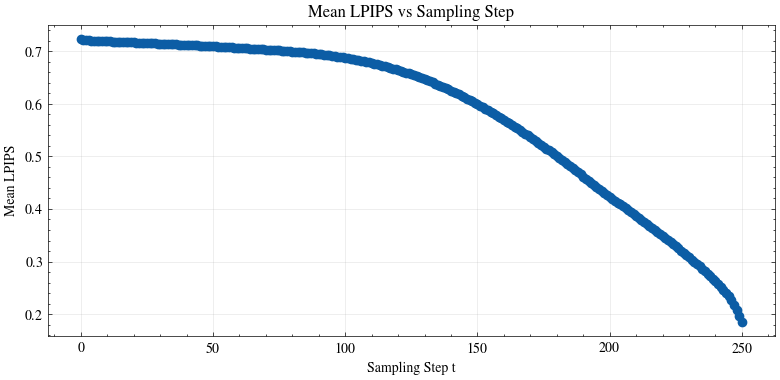

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.221667..1.996299].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2532723..1.968051].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2328811..1.9542327].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1303502..1.8826894].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9392507..1.7427132].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6819328..1.5447463].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.41003835.

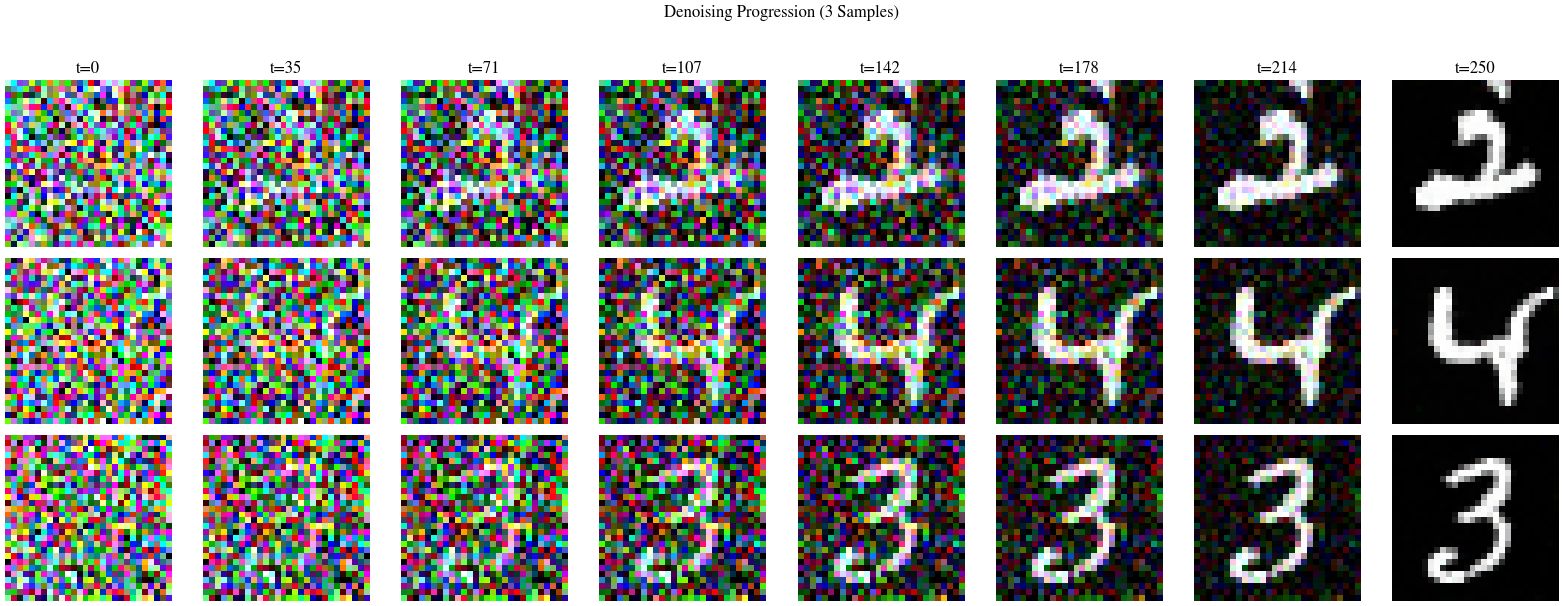

In [63]:
# Compute mean LPIPS vs timestep using validation set + visualize denoising progress

# --- 1) Build validation subset (1000 samples) ---
num_val_samples = 15
val_subset_indices = torch.randperm(len(test_ds))[:num_val_samples]
val_images = []

print("Loading validation samples...")
for idx in tqdm(val_subset_indices):
    img, _ = test_ds[idx]
    val_images.append(img)

val_images = torch.stack(val_images).to(device)

# Resize + normalize for LPIPS
val_resized = resize_for_lpips(val_images)
val_normalized = normalize_for_lpips(val_resized)

# --- 2) Sample 500 images with all timesteps ---
num_gen_samples = 15
print("Generating samples with all timesteps...")
loaded_diffusion.eval()
with torch.no_grad():
    all_samples = loaded_diffusion.sample(batch_size=num_gen_samples, return_all_timesteps=True)

# Handle shapes: expect (t, b, c, h, w) or (b, t, c, h, w) or list of tensors
if isinstance(all_samples, (list, tuple)):
    all_samples = torch.stack(all_samples)  # (t, b, c, h, w)
elif all_samples.dim() == 5 and all_samples.shape[0] == num_gen_samples:
    all_samples = all_samples.permute(1, 0, 2, 3, 4)  # (t, b, c, h, w)

num_steps = all_samples.shape[0]
print(f"Captured {num_steps} timesteps")

# --- 3) Mean nearest-neighbor LPIPS per timestep ---
def min_lpips_to_set(gen_images, ref_images, batch_size=8):
    mins = []
    n_ref = ref_images.shape[0]
    for i in range(0, gen_images.shape[0], batch_size):
        gb = gen_images[i:i+batch_size]  # (b, c, h, w)
        b = gb.shape[0]
        gb_exp = gb[:, None, ...].repeat(1, n_ref, 1, 1, 1).reshape(b * n_ref, *gb.shape[1:])
        ref_exp = ref_images.repeat(b, 1, 1, 1)
        d = lpips_model(gb_exp, ref_exp).view(b, n_ref)
        mins.append(d.min(dim=1).values.detach().cpu())
    return torch.cat(mins)

mean_lpips_per_t = []
print("Computing mean LPIPS per timestep...")
with torch.no_grad():
    for t in tqdm(range(num_steps), desc="LPIPS per t"):
        gen_t = all_samples[t].to(device)
        gen_t_resized = resize_for_lpips(gen_t)
        gen_t_normalized = normalize_for_lpips(gen_t_resized)
        mins = min_lpips_to_set(gen_t_normalized, val_normalized, batch_size=8)
        mean_lpips_per_t.append(mins.mean().item())

# --- 4) Plot mean LPIPS vs timestep ---
plt.figure(figsize=(8, 4))
plt.plot(range(num_steps), mean_lpips_per_t, marker='o', linewidth=0.5)
plt.xlabel('Sampling Step t')
plt.ylabel('Mean LPIPS')
plt.title('Mean LPIPS vs Sampling Step')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- 5) Visualize denoising progression for 3 samples ---
num_samples_to_show = 3
num_snapshots = 8
sample_indices = torch.randperm(num_gen_samples)[:num_samples_to_show].tolist()
snapshot_steps = np.linspace(0, num_steps - 1, num_snapshots, dtype=int)

fig, axes = plt.subplots(num_samples_to_show, num_snapshots, figsize=(2*num_snapshots, 2*num_samples_to_show))
for r, sample_idx in enumerate(sample_indices):
    for c, t in enumerate(snapshot_steps):
        ax = axes[r, c] if num_samples_to_show > 1 else axes[c]
        img = all_samples[t, sample_idx].cpu().permute(1, 2, 0).squeeze()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        if r == 0:
            ax.set_title(f"t={t}")

plt.suptitle('Denoising Progression (3 Samples)', y=1.02)
plt.tight_layout()
plt.show()

Finding nearest neighbors...


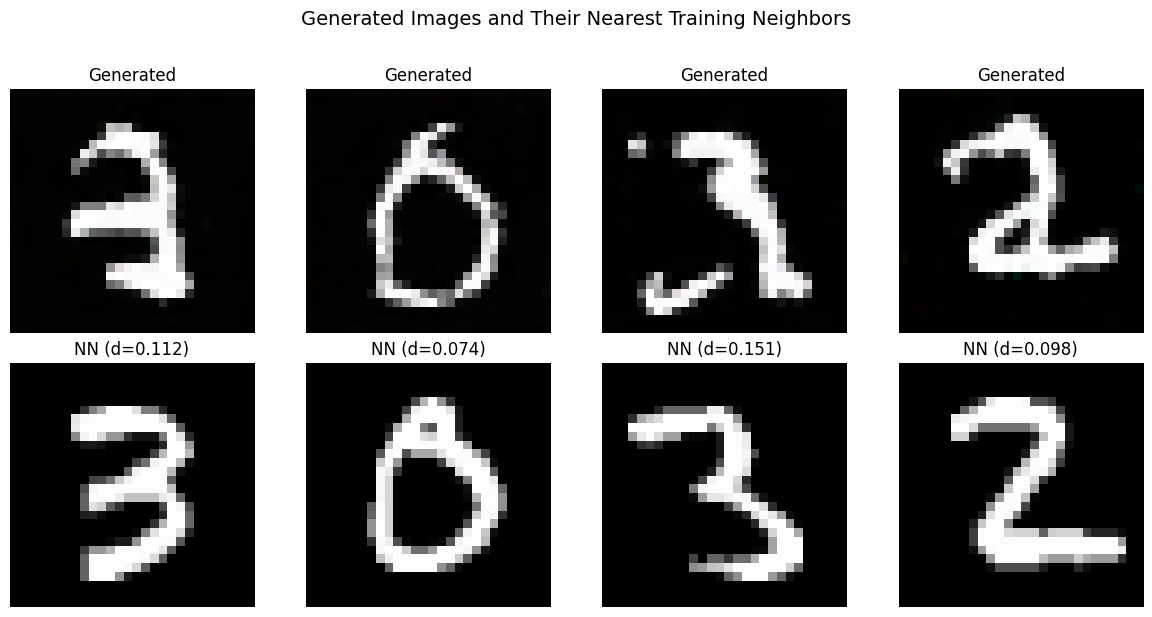


Nearest neighbor distances:
Sample 1: 0.1118
Sample 2: 0.0735
Sample 3: 0.1513
Sample 4: 0.0977


In [30]:
# Find nearest neighbors for 4 generated samples and visualize

# Select 4 random generated images
num_samples_to_show = 4
sample_indices = torch.randperm(len(sampled_images))[:num_samples_to_show]

nearest_neighbors = []
nearest_distances = []

print("Finding nearest neighbors...")
with torch.no_grad():
    for idx in sample_indices:
        gen_img = generated_normalized[idx].unsqueeze(0)
        gen_img_batch = gen_img.repeat(len(train_normalized), 1, 1, 1)
        
        # Compute distances to all training images
        distances = lpips_model(gen_img_batch, train_normalized).squeeze()
        
        # Find nearest neighbor
        min_idx = distances.argmin().item()
        min_dist = distances[min_idx].item()
        
        nearest_neighbors.append(min_idx)
        nearest_distances.append(min_dist)

# Visualize: Top row = generated, Bottom row = nearest neighbor
fig, axes = plt.subplots(2, num_samples_to_show, figsize=(12, 6))

for i, (gen_idx, nn_idx, dist) in enumerate(zip(sample_indices, nearest_neighbors, nearest_distances)):
    # Top row: Generated images
    gen_img = sampled_images[gen_idx].cpu().permute(1, 2, 0).squeeze()
    axes[0, i].imshow(gen_img, cmap='gray')
    axes[0, i].set_title(f'Generated')
    axes[0, i].axis('off')
    
    # Bottom row: Nearest training images
    train_img = train_images[nn_idx].cpu().permute(1, 2, 0).squeeze()
    axes[1, i].imshow(train_img, cmap='gray')
    axes[1, i].set_title(f'NN (d={dist:.3f})')
    axes[1, i].axis('off')

plt.suptitle('Generated Images and Their Nearest Training Neighbors', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\nNearest neighbor distances:")
for i, dist in enumerate(nearest_distances):
    print(f"Sample {i+1}: {dist:.4f}")